In [1]:
# Use legacy Keras
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'

In [2]:
from typing import Dict, Text

import keras
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs

RANDOM_STATE = 42

tf.random.set_seed(RANDOM_STATE)

2024-08-28 17:25:18.011658: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-28 17:25:18.027964: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-28 17:25:18.032061: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-28 17:25:18.044552: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-28 17:25:19.059780: W tensorflow/compiler/tf2

## Preprocess

### Download Datasets

In [3]:
# Download the dataset and cache them as `tfrecord`

ratings_dataset, ratings_dataset_info = tfds.load(
    # Options: '25m-ratings', 'latest-small-ratings', '100k-ratings', '1m-ratings', '20m-ratings'
    name = 'movielens/100k-ratings',
    # MovieLense has only the `train` split.
    split = 'train',
    # Include metadata like version, description, homepage, citation, etc.
    with_info = True
)
print(f"Ratings count:", ratings_dataset.__len__().numpy())

movies_dataset, movies_dataset_info = tfds.load(
    # Options: '25m-movies', 'latest-small-movies', '100k-movies', '1m-movies', '20m-movies'
    name = 'movielens/100k-movies',
    # MovieLense has only the `train` split.
    split = 'train',
    # Include metadata like version, description, homepage, citation, etc.
    with_info = True
)
print(f"Movies count:", movies_dataset.__len__().numpy())

I0000 00:00:1724853320.942537  199471 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724853320.974534  199471 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724853320.974635  199471 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724853320.978813  199471 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724853320.978916  199471 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Ratings count: 100000
Movies count: 1682


### Feature Selection

In [4]:
# Feature selection
ratings_dataset = ratings_dataset.map(
    lambda rating: {
        # `user_id` is useful as a user identifier.
        'user_id': rating['user_id'],
        # `movie_id` is useful as a movie identifier.
        'movie_id': rating['movie_id'],
        # `movie_title` is useful as a textual information about the movie.
        'movie_title': rating['movie_title'],
        # `user_rating` shows the user's level of interest to a movie.
        'user_rating': rating['user_rating'],
        # `timestamp` will allow us to model the effect of time.
        'timestamp': rating['timestamp']
    }
)

### Dataset Splitting

In [5]:
# Shuffle the elements of the dataset randomly.
ratings_dataset_shuffled = ratings_dataset.shuffle(
    # The new dataset will be sampled from a buffer window of first `buffer_size`
    # elements of the dataset
    buffer_size = 100_000,
    # The random seed used to create the distribution.
    seed = RANDOM_STATE,
    # `list(dataset.as_numpy_iterator()` yields different result for each call
    # Because reshuffle_each_iteration defaults to True.
    reshuffle_each_iteration = False
)

# Split dataset randomly (80% for training and 20% for validation)
trainset_size: int  = 0.8 * ratings_dataset.__len__().numpy()

ratings_trainset = ratings_dataset_shuffled.take(trainset_size)
ratings_validset = ratings_dataset_shuffled.skip(trainset_size)

print(f"trainset_size:", ratings_trainset.__len__().numpy())
print(f"validset_size:", ratings_validset.__len__().numpy())

trainset_size: 80000
validset_size: 20000


In [6]:
# Create implicit ratings for Retieval
retrieval_ratings_trainset = ratings_trainset.map(
    lambda rating: {
        'user_id': rating['user_id'],
        'movie_id': rating['movie_id'],
        'movie_title': rating['movie_title'],
    }
)

In [7]:
from src.towers.query import QueryTower
from src.towers.candidate import CandidateTower
from src.retrieval import RetrievalModel

candidate_tower = CandidateTower(
    dataset = retrieval_ratings_trainset,
    embedding_dim = 4
)

query_tower = QueryTower(
    dataset = retrieval_ratings_trainset,
    embedding_dim = 4
)

[INFO - 2024-08-28 17:28:00]	`MovieEmbeddingModel.__create_id_embedding_layer()` executed in 157.8 seconds.
[INFO - 2024-08-28 17:34:51]	`MovieEmbeddingModel.__create_title_embedding_layer()` executed in 411.2 seconds.
[INFO - 2024-08-28 17:37:51]	`UserEmbeddingModel.__create_id_embedding_layer()` executed in 179.5 seconds.


In [8]:
# We are using just `movie_id` feature for making the candidates representation
candidates_corpus_dataset = movies_dataset.map(
    lambda movie: {
        'movie_id': movie['movie_id'],
        'movie_title': movie['movie_title']
    }
)

retrieval_ratings_validset = ratings_dataset.map(
    lambda rating: {
        'user_id': rating['user_id'],
        'movie_id': rating['movie_id'],
    }
)

factorized_top_k_metrics = tfrs.metrics.FactorizedTopK(
    # dataset of candidate embeddings from which candidates should be retrieved
    candidates = candidates_corpus_dataset.batch(128).map(
        candidate_tower
    )
)

In [9]:
# The task computes the metrics and return the in-batch softmax loss.
# Because the metrics range over the entire candidate set, they are usually much
# slower to compute. Consider setting `compute_metrics=False` in Retrieval
# costructor during training to save the time in computing the metrics.
retrieval_task_layer = tfrs.tasks.Retrieval(
    metrics = factorized_top_k_metrics
)
retrieval_model = RetrievalModel(
    query_tower = query_tower,
    candidate_tower = candidate_tower,
    task = retrieval_task_layer
)

In [10]:
optimizer = tf.keras.optimizers.Adagrad(learning_rate = 0.1)
retrieval_model.compile(optimizer = optimizer)

In [12]:
# Shuffle the training data for each epoch.
# Batch and cache both the training and evaluation data.
# `cache()` method caches the elements in the dataset in memory. To caches data
# in a file pass the `filename` argument to the method: cache(filename='')
# The first time the dataset is iterated over, its elements will be cached
# either in the specified file or in memory. Subsequent iterations will use the
# cached data.
retrieval_cached_ratings_trainset = retrieval_ratings_trainset.shuffle(100_000).batch(1024).cache()
retrieval_cached_ratings_validset = retrieval_ratings_validset.batch(1024).cache()

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    patience = 3
)

history = retrieval_model.fit(
    retrieval_cached_ratings_trainset,
    # validation_data = retrieval_cached_ratings_validset,
    # validation_freq = 1,
    epochs = 100,
    callbacks = [
        early_stopping_callback
    ]
)

Epoch 1/100


79/79 [==============================] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6794.4842 - regularization_loss: 0.0000e+00 - total_loss: 6794.4842WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categorical_accuracy,factorized_top_k/top_5_categorical_accuracy,factorized_top_k/top_10_categorical_accuracy,factorized_top_k/top_50_categorical_accuracy,factorized_top_k/top_100_categorical_accuracy,loss,regularization_loss,total_loss


79/79 [==============================] - 11s 43ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6716.7607 - regularization_loss: 0.0000e+00 - total_loss: 6716.7607
Epoch 2/100
76/79 [===========================>..] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6813.2402 - regularization_loss: 0.0000e+00 - total_loss: 6813.2402WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categori

79/79 [==============================] - 1s 14ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6656.4671 - regularization_loss: 0.0000e+00 - total_loss: 6656.4671
Epoch 3/100
77/79 [============================>.] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6772.4621 - regularization_loss: 0.0000e+00 - total_loss: 6772.4621WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categoric

79/79 [==============================] - 1s 14ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6617.0999 - regularization_loss: 0.0000e+00 - total_loss: 6617.0999
Epoch 4/100
78/79 [============================>.] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6742.8916 - regularization_loss: 0.0000e+00 - total_loss: 6742.8916WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categoric

79/79 [==============================] - 1s 15ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6588.3112 - regularization_loss: 0.0000e+00 - total_loss: 6588.3112
Epoch 5/100
78/79 [============================>.] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6719.5280 - regularization_loss: 0.0000e+00 - total_loss: 6719.5280WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categoric

79/79 [==============================] - 1s 16ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6565.4864 - regularization_loss: 0.0000e+00 - total_loss: 6565.4864
Epoch 6/100
76/79 [===========================>..] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6705.6494 - regularization_loss: 0.0000e+00 - total_loss: 6705.6494WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categoric

79/79 [==============================] - 1s 19ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6551.4315 - regularization_loss: 0.0000e+00 - total_loss: 6551.4315
Epoch 7/100
76/79 [===========================>..] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6696.0849 - regularization_loss: 0.0000e+00 - total_loss: 6696.0849WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categoric

79/79 [==============================] - 1s 17ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6542.1017 - regularization_loss: 0.0000e+00 - total_loss: 6542.1017
Epoch 8/100
76/79 [===========================>..] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6689.1142 - regularization_loss: 0.0000e+00 - total_loss: 6689.1142WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categoric

79/79 [==============================] - 1s 18ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6535.2966 - regularization_loss: 0.0000e+00 - total_loss: 6535.2966
Epoch 9/100
78/79 [============================>.] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6683.0711 - regularization_loss: 0.0000e+00 - total_loss: 6683.0711WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categoric

79/79 [==============================] - 1s 17ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6529.8806 - regularization_loss: 0.0000e+00 - total_loss: 6529.8806
Epoch 10/100
78/79 [============================>.] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6678.2127 - regularization_loss: 0.0000e+00 - total_loss: 6678.2127WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categori

79/79 [==============================] - 1s 17ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6525.1347 - regularization_loss: 0.0000e+00 - total_loss: 6525.1347
Epoch 11/100
78/79 [============================>.] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6673.3636 - regularization_loss: 0.0000e+00 - total_loss: 6673.3636WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categori

79/79 [==============================] - 1s 17ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6520.3970 - regularization_loss: 0.0000e+00 - total_loss: 6520.3970
Epoch 12/100
77/79 [============================>.] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6667.8033 - regularization_loss: 0.0000e+00 - total_loss: 6667.8033WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categori

79/79 [==============================] - 1s 17ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6514.7321 - regularization_loss: 0.0000e+00 - total_loss: 6514.7321
Epoch 13/100
79/79 [==============================] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6582.0047 - regularization_loss: 0.0000e+00 - total_loss: 6582.0047WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categori

79/79 [==============================] - 1s 17ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6506.6463 - regularization_loss: 0.0000e+00 - total_loss: 6506.6463
Epoch 14/100
76/79 [===========================>..] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6648.5112 - regularization_loss: 0.0000e+00 - total_loss: 6648.5112WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categori

79/79 [==============================] - 1s 17ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6495.4147 - regularization_loss: 0.0000e+00 - total_loss: 6495.4147
Epoch 15/100
78/79 [============================>.] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6636.1225 - regularization_loss: 0.0000e+00 - total_loss: 6636.1225WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categori

79/79 [==============================] - 1s 17ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6484.0180 - regularization_loss: 0.0000e+00 - total_loss: 6484.0180
Epoch 16/100
77/79 [============================>.] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6626.8949 - regularization_loss: 0.0000e+00 - total_loss: 6626.8949WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categori

79/79 [==============================] - 1s 17ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6474.8277 - regularization_loss: 0.0000e+00 - total_loss: 6474.8277
Epoch 17/100
76/79 [===========================>..] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6620.1491 - regularization_loss: 0.0000e+00 - total_loss: 6620.1491WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categori

79/79 [==============================] - 1s 17ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6467.7810 - regularization_loss: 0.0000e+00 - total_loss: 6467.7810
Epoch 18/100
77/79 [============================>.] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6614.1675 - regularization_loss: 0.0000e+00 - total_loss: 6614.1675WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categori

79/79 [==============================] - 1s 18ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6462.4224 - regularization_loss: 0.0000e+00 - total_loss: 6462.4224
Epoch 19/100
77/79 [============================>.] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6609.9424 - regularization_loss: 0.0000e+00 - total_loss: 6609.9424WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categori

79/79 [==============================] - 1s 16ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6458.2992 - regularization_loss: 0.0000e+00 - total_loss: 6458.2992
Epoch 20/100
76/79 [===========================>..] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6607.0791 - regularization_loss: 0.0000e+00 - total_loss: 6607.0791WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categori

79/79 [==============================] - 1s 17ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6455.0552 - regularization_loss: 0.0000e+00 - total_loss: 6455.0552
Epoch 21/100
77/79 [============================>.] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6603.9406 - regularization_loss: 0.0000e+00 - total_loss: 6603.9406WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categori

79/79 [==============================] - 1s 17ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6452.4386 - regularization_loss: 0.0000e+00 - total_loss: 6452.4386
Epoch 22/100
78/79 [============================>.] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6601.6111 - regularization_loss: 0.0000e+00 - total_loss: 6601.6111WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categori

79/79 [==============================] - 1s 18ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6450.2777 - regularization_loss: 0.0000e+00 - total_loss: 6450.2777
Epoch 23/100
79/79 [==============================] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6523.1445 - regularization_loss: 0.0000e+00 - total_loss: 6523.1445WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categori

79/79 [==============================] - 1s 17ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6448.4547 - regularization_loss: 0.0000e+00 - total_loss: 6448.4547
Epoch 24/100
79/79 [==============================] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6521.5615 - regularization_loss: 0.0000e+00 - total_loss: 6521.5615WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categori

79/79 [==============================] - 1s 17ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6446.8882 - regularization_loss: 0.0000e+00 - total_loss: 6446.8882
Epoch 25/100
78/79 [============================>.] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6596.7530 - regularization_loss: 0.0000e+00 - total_loss: 6596.7530WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categori

79/79 [==============================] - 1s 18ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6445.5208 - regularization_loss: 0.0000e+00 - total_loss: 6445.5208
Epoch 26/100
77/79 [============================>.] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6595.6182 - regularization_loss: 0.0000e+00 - total_loss: 6595.6182WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categori

79/79 [==============================] - 1s 17ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6444.3114 - regularization_loss: 0.0000e+00 - total_loss: 6444.3114
Epoch 27/100
78/79 [============================>.] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6594.4126 - regularization_loss: 0.0000e+00 - total_loss: 6594.4126WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categori

79/79 [==============================] - 1s 15ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6443.2293 - regularization_loss: 0.0000e+00 - total_loss: 6443.2293
Epoch 28/100
78/79 [============================>.] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6593.4140 - regularization_loss: 0.0000e+00 - total_loss: 6593.4140WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categori

79/79 [==============================] - 1s 16ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6442.2517 - regularization_loss: 0.0000e+00 - total_loss: 6442.2517
Epoch 29/100
77/79 [============================>.] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6592.5950 - regularization_loss: 0.0000e+00 - total_loss: 6592.5950WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categori

79/79 [==============================] - 1s 18ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6441.3611 - regularization_loss: 0.0000e+00 - total_loss: 6441.3611
Epoch 30/100
77/79 [============================>.] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6591.7573 - regularization_loss: 0.0000e+00 - total_loss: 6591.7573WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categori

79/79 [==============================] - 1s 17ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6440.5440 - regularization_loss: 0.0000e+00 - total_loss: 6440.5440
Epoch 31/100
79/79 [==============================] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6514.3878 - regularization_loss: 0.0000e+00 - total_loss: 6514.3878WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categori

79/79 [==============================] - 1s 17ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6439.7898 - regularization_loss: 0.0000e+00 - total_loss: 6439.7898
Epoch 32/100
76/79 [===========================>..] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6590.7038 - regularization_loss: 0.0000e+00 - total_loss: 6590.7038WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categori

79/79 [==============================] - 1s 14ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6439.0896 - regularization_loss: 0.0000e+00 - total_loss: 6439.0896
Epoch 33/100
78/79 [============================>.] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6589.5157 - regularization_loss: 0.0000e+00 - total_loss: 6589.5157WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categori

79/79 [==============================] - 1s 15ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6438.4366 - regularization_loss: 0.0000e+00 - total_loss: 6438.4366
Epoch 34/100
76/79 [===========================>..] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6589.4046 - regularization_loss: 0.0000e+00 - total_loss: 6589.4046WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categori

79/79 [==============================] - 1s 17ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6437.8251 - regularization_loss: 0.0000e+00 - total_loss: 6437.8251
Epoch 35/100
77/79 [============================>.] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6588.3780 - regularization_loss: 0.0000e+00 - total_loss: 6588.3780WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categori

79/79 [==============================] - 1s 15ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6437.2502 - regularization_loss: 0.0000e+00 - total_loss: 6437.2502
Epoch 36/100
78/79 [============================>.] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6587.7483 - regularization_loss: 0.0000e+00 - total_loss: 6587.7483WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categori

79/79 [==============================] - 1s 16ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6436.7078 - regularization_loss: 0.0000e+00 - total_loss: 6436.7078
Epoch 37/100
79/79 [==============================] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6510.7533 - regularization_loss: 0.0000e+00 - total_loss: 6510.7533WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categori

79/79 [==============================] - 1s 16ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6436.1948 - regularization_loss: 0.0000e+00 - total_loss: 6436.1948
Epoch 38/100
78/79 [============================>.] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6586.7258 - regularization_loss: 0.0000e+00 - total_loss: 6586.7258WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categori

79/79 [==============================] - 1s 16ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6435.7080 - regularization_loss: 0.0000e+00 - total_loss: 6435.7080
Epoch 39/100
78/79 [============================>.] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6586.2525 - regularization_loss: 0.0000e+00 - total_loss: 6586.2525WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categori

79/79 [==============================] - 1s 17ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6435.2453 - regularization_loss: 0.0000e+00 - total_loss: 6435.2453
Epoch 40/100
76/79 [===========================>..] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6586.2963 - regularization_loss: 0.0000e+00 - total_loss: 6586.2963WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categori

79/79 [==============================] - 1s 14ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6434.8040 - regularization_loss: 0.0000e+00 - total_loss: 6434.8040
Epoch 41/100
79/79 [==============================] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6508.9205 - regularization_loss: 0.0000e+00 - total_loss: 6508.9205WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categori

79/79 [==============================] - 1s 16ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6434.3824 - regularization_loss: 0.0000e+00 - total_loss: 6434.3824
Epoch 42/100
79/79 [==============================] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6508.5128 - regularization_loss: 0.0000e+00 - total_loss: 6508.5128WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categori

79/79 [==============================] - 1s 17ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6433.9794 - regularization_loss: 0.0000e+00 - total_loss: 6433.9794
Epoch 43/100
77/79 [============================>.] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6584.6205 - regularization_loss: 0.0000e+00 - total_loss: 6584.6205WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categori

79/79 [==============================] - 1s 17ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6433.5928 - regularization_loss: 0.0000e+00 - total_loss: 6433.5928
Epoch 44/100
76/79 [===========================>..] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6584.6653 - regularization_loss: 0.0000e+00 - total_loss: 6584.6653WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categori

79/79 [==============================] - 1s 17ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6433.2216 - regularization_loss: 0.0000e+00 - total_loss: 6433.2216
Epoch 45/100
76/79 [===========================>..] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6584.2971 - regularization_loss: 0.0000e+00 - total_loss: 6584.2971WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categori

79/79 [==============================] - 1s 17ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6432.8647 - regularization_loss: 0.0000e+00 - total_loss: 6432.8647
Epoch 46/100
76/79 [===========================>..] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6583.9423 - regularization_loss: 0.0000e+00 - total_loss: 6583.9423WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categori

79/79 [==============================] - 1s 18ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6432.5209 - regularization_loss: 0.0000e+00 - total_loss: 6432.5209
Epoch 47/100
79/79 [==============================] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6506.7021 - regularization_loss: 0.0000e+00 - total_loss: 6506.7021WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categori

79/79 [==============================] - 1s 17ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6432.1896 - regularization_loss: 0.0000e+00 - total_loss: 6432.1896
Epoch 48/100
78/79 [============================>.] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6582.7979 - regularization_loss: 0.0000e+00 - total_loss: 6582.7979WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categori

79/79 [==============================] - 1s 18ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6431.8698 - regularization_loss: 0.0000e+00 - total_loss: 6431.8698
Epoch 49/100
79/79 [==============================] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6506.0658 - regularization_loss: 0.0000e+00 - total_loss: 6506.0658WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categori

79/79 [==============================] - 1s 17ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6431.5607 - regularization_loss: 0.0000e+00 - total_loss: 6431.5607
Epoch 50/100
78/79 [============================>.] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6582.1751 - regularization_loss: 0.0000e+00 - total_loss: 6582.1751WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categori

79/79 [==============================] - 1s 18ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6431.2617 - regularization_loss: 0.0000e+00 - total_loss: 6431.2617
Epoch 51/100
79/79 [==============================] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6505.4702 - regularization_loss: 0.0000e+00 - total_loss: 6505.4702WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categori

79/79 [==============================] - 1s 17ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6430.9721 - regularization_loss: 0.0000e+00 - total_loss: 6430.9721
Epoch 52/100
77/79 [============================>.] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6581.6349 - regularization_loss: 0.0000e+00 - total_loss: 6581.6349WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categori

79/79 [==============================] - 1s 18ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6430.6915 - regularization_loss: 0.0000e+00 - total_loss: 6430.6915
Epoch 53/100
77/79 [============================>.] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6581.3536 - regularization_loss: 0.0000e+00 - total_loss: 6581.3536WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categori

79/79 [==============================] - 1s 17ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6430.4185 - regularization_loss: 0.0000e+00 - total_loss: 6430.4185
Epoch 54/100
76/79 [===========================>..] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6581.4969 - regularization_loss: 0.0000e+00 - total_loss: 6581.4969WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categori

79/79 [==============================] - 1s 17ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6430.1540 - regularization_loss: 0.0000e+00 - total_loss: 6430.1540
Epoch 55/100
77/79 [============================>.] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6580.8156 - regularization_loss: 0.0000e+00 - total_loss: 6580.8156WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categori

79/79 [==============================] - 1s 15ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6429.8962 - regularization_loss: 0.0000e+00 - total_loss: 6429.8962
Epoch 56/100
78/79 [============================>.] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6580.5199 - regularization_loss: 0.0000e+00 - total_loss: 6580.5199WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categori

79/79 [==============================] - 1s 17ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6429.6460 - regularization_loss: 0.0000e+00 - total_loss: 6429.6460
Epoch 57/100
79/79 [==============================] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6503.8815 - regularization_loss: 0.0000e+00 - total_loss: 6503.8815WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categori

79/79 [==============================] - 1s 15ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6429.4025 - regularization_loss: 0.0000e+00 - total_loss: 6429.4025
Epoch 58/100
79/79 [==============================] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6503.6412 - regularization_loss: 0.0000e+00 - total_loss: 6503.6412WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categori

79/79 [==============================] - 1s 16ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6429.1651 - regularization_loss: 0.0000e+00 - total_loss: 6429.1651
Epoch 59/100
78/79 [============================>.] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6579.7901 - regularization_loss: 0.0000e+00 - total_loss: 6579.7901WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categori

79/79 [==============================] - 1s 16ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6428.9340 - regularization_loss: 0.0000e+00 - total_loss: 6428.9340
Epoch 60/100
76/79 [===========================>..] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6580.0005 - regularization_loss: 0.0000e+00 - total_loss: 6580.0005WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categori

79/79 [==============================] - 1s 15ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6428.7084 - regularization_loss: 0.0000e+00 - total_loss: 6428.7084
Epoch 61/100
77/79 [============================>.] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6579.3641 - regularization_loss: 0.0000e+00 - total_loss: 6579.3641WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categori

79/79 [==============================] - 1s 16ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6428.4883 - regularization_loss: 0.0000e+00 - total_loss: 6428.4883
Epoch 62/100
76/79 [===========================>..] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6579.5498 - regularization_loss: 0.0000e+00 - total_loss: 6579.5498WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categori

79/79 [==============================] - 1s 15ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6428.2734 - regularization_loss: 0.0000e+00 - total_loss: 6428.2734
Epoch 63/100
78/79 [============================>.] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6578.8977 - regularization_loss: 0.0000e+00 - total_loss: 6578.8977WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categori

79/79 [==============================] - 1s 15ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6428.0636 - regularization_loss: 0.0000e+00 - total_loss: 6428.0636
Epoch 64/100
78/79 [============================>.] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6578.6871 - regularization_loss: 0.0000e+00 - total_loss: 6578.6871WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categori

79/79 [==============================] - 1s 16ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6427.8583 - regularization_loss: 0.0000e+00 - total_loss: 6427.8583
Epoch 65/100
77/79 [============================>.] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6578.5073 - regularization_loss: 0.0000e+00 - total_loss: 6578.5073WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categori

79/79 [==============================] - 1s 17ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6427.6578 - regularization_loss: 0.0000e+00 - total_loss: 6427.6578
Epoch 66/100
79/79 [==============================] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6501.9161 - regularization_loss: 0.0000e+00 - total_loss: 6501.9161WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categori

79/79 [==============================] - 1s 17ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6427.4613 - regularization_loss: 0.0000e+00 - total_loss: 6427.4613
Epoch 67/100
76/79 [===========================>..] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6578.5085 - regularization_loss: 0.0000e+00 - total_loss: 6578.5085WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categori

79/79 [==============================] - 1s 17ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6427.2694 - regularization_loss: 0.0000e+00 - total_loss: 6427.2694
Epoch 68/100
79/79 [==============================] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6501.5310 - regularization_loss: 0.0000e+00 - total_loss: 6501.5310WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categori

79/79 [==============================] - 1s 18ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6427.0811 - regularization_loss: 0.0000e+00 - total_loss: 6427.0811
Epoch 69/100
78/79 [============================>.] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6577.7008 - regularization_loss: 0.0000e+00 - total_loss: 6577.7008WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categori

79/79 [==============================] - 1s 17ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6426.8968 - regularization_loss: 0.0000e+00 - total_loss: 6426.8968
Epoch 70/100
78/79 [============================>.] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6577.5154 - regularization_loss: 0.0000e+00 - total_loss: 6577.5154WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categori

79/79 [==============================] - 1s 18ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6426.7161 - regularization_loss: 0.0000e+00 - total_loss: 6426.7161
Epoch 71/100
76/79 [===========================>..] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6577.7502 - regularization_loss: 0.0000e+00 - total_loss: 6577.7502WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categori

79/79 [==============================] - 1s 15ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6426.5390 - regularization_loss: 0.0000e+00 - total_loss: 6426.5390
Epoch 72/100
77/79 [============================>.] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6577.1727 - regularization_loss: 0.0000e+00 - total_loss: 6577.1727WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categori

79/79 [==============================] - 1s 14ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6426.3652 - regularization_loss: 0.0000e+00 - total_loss: 6426.3652
Epoch 73/100
78/79 [============================>.] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6576.9805 - regularization_loss: 0.0000e+00 - total_loss: 6576.9805WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categori

79/79 [==============================] - 1s 16ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6426.1949 - regularization_loss: 0.0000e+00 - total_loss: 6426.1949
Epoch 74/100
79/79 [==============================] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6500.4638 - regularization_loss: 0.0000e+00 - total_loss: 6500.4638WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categori

79/79 [==============================] - 1s 16ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6426.0275 - regularization_loss: 0.0000e+00 - total_loss: 6426.0275
Epoch 75/100
77/79 [============================>.] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6576.6539 - regularization_loss: 0.0000e+00 - total_loss: 6576.6539WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categori

79/79 [==============================] - 1s 15ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6425.8632 - regularization_loss: 0.0000e+00 - total_loss: 6425.8632
Epoch 76/100
77/79 [============================>.] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6576.4870 - regularization_loss: 0.0000e+00 - total_loss: 6576.4870WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categori

79/79 [==============================] - 1s 14ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6425.7016 - regularization_loss: 0.0000e+00 - total_loss: 6425.7016
Epoch 77/100
77/79 [============================>.] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6576.3232 - regularization_loss: 0.0000e+00 - total_loss: 6576.3232WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categori

79/79 [==============================] - 1s 14ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6425.5432 - regularization_loss: 0.0000e+00 - total_loss: 6425.5432
Epoch 78/100
77/79 [============================>.] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6576.1620 - regularization_loss: 0.0000e+00 - total_loss: 6576.1620WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categori

79/79 [==============================] - 1s 15ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6425.3873 - regularization_loss: 0.0000e+00 - total_loss: 6425.3873
Epoch 79/100
77/79 [============================>.] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6576.0037 - regularization_loss: 0.0000e+00 - total_loss: 6576.0037WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categori

79/79 [==============================] - 1s 16ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6425.2341 - regularization_loss: 0.0000e+00 - total_loss: 6425.2341
Epoch 80/100
77/79 [============================>.] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6575.8479 - regularization_loss: 0.0000e+00 - total_loss: 6575.8479WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categori

79/79 [==============================] - 1s 18ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6425.0835 - regularization_loss: 0.0000e+00 - total_loss: 6425.0835
Epoch 81/100
77/79 [============================>.] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6575.6948 - regularization_loss: 0.0000e+00 - total_loss: 6575.6948WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categori

79/79 [==============================] - 1s 17ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6424.9354 - regularization_loss: 0.0000e+00 - total_loss: 6424.9354
Epoch 82/100
78/79 [============================>.] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6575.5378 - regularization_loss: 0.0000e+00 - total_loss: 6575.5378WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categori

79/79 [==============================] - 1s 18ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6424.7897 - regularization_loss: 0.0000e+00 - total_loss: 6424.7897
Epoch 83/100
77/79 [============================>.] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6575.3960 - regularization_loss: 0.0000e+00 - total_loss: 6575.3960WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categori

79/79 [==============================] - 1s 17ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6424.6465 - regularization_loss: 0.0000e+00 - total_loss: 6424.6465
Epoch 84/100
76/79 [===========================>..] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6575.6350 - regularization_loss: 0.0000e+00 - total_loss: 6575.6350WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categori

79/79 [==============================] - 1s 18ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6424.5053 - regularization_loss: 0.0000e+00 - total_loss: 6424.5053
Epoch 85/100
77/79 [============================>.] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6575.1063 - regularization_loss: 0.0000e+00 - total_loss: 6575.1063WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categori

79/79 [==============================] - 1s 17ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6424.3665 - regularization_loss: 0.0000e+00 - total_loss: 6424.3665
Epoch 86/100
78/79 [============================>.] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6574.9627 - regularization_loss: 0.0000e+00 - total_loss: 6574.9627WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categori

79/79 [==============================] - 1s 17ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6424.2299 - regularization_loss: 0.0000e+00 - total_loss: 6424.2299
Epoch 87/100
79/79 [==============================] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6498.5058 - regularization_loss: 0.0000e+00 - total_loss: 6498.5058WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categori

79/79 [==============================] - 1s 18ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6424.0952 - regularization_loss: 0.0000e+00 - total_loss: 6424.0952
Epoch 88/100
78/79 [============================>.] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6574.6881 - regularization_loss: 0.0000e+00 - total_loss: 6574.6881WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categori

79/79 [==============================] - 1s 17ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6423.9626 - regularization_loss: 0.0000e+00 - total_loss: 6423.9626
Epoch 89/100
78/79 [============================>.] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6574.5539 - regularization_loss: 0.0000e+00 - total_loss: 6574.5539WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categori

79/79 [==============================] - 1s 17ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6423.8320 - regularization_loss: 0.0000e+00 - total_loss: 6423.8320
Epoch 90/100
76/79 [===========================>..] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6574.7991 - regularization_loss: 0.0000e+00 - total_loss: 6574.7991WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categori

79/79 [==============================] - 1s 16ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6423.7033 - regularization_loss: 0.0000e+00 - total_loss: 6423.7033
Epoch 91/100
77/79 [============================>.] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6574.2885 - regularization_loss: 0.0000e+00 - total_loss: 6574.2885WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categori

79/79 [==============================] - 1s 18ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6423.5764 - regularization_loss: 0.0000e+00 - total_loss: 6423.5764
Epoch 92/100
78/79 [============================>.] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6574.1628 - regularization_loss: 0.0000e+00 - total_loss: 6574.1628WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categori

79/79 [==============================] - 1s 17ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6423.4514 - regularization_loss: 0.0000e+00 - total_loss: 6423.4514
Epoch 93/100
77/79 [============================>.] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6574.0315 - regularization_loss: 0.0000e+00 - total_loss: 6574.0315WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categori

79/79 [==============================] - 1s 17ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6423.3282 - regularization_loss: 0.0000e+00 - total_loss: 6423.3282
Epoch 94/100
78/79 [============================>.] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6573.9113 - regularization_loss: 0.0000e+00 - total_loss: 6573.9113WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categori

79/79 [==============================] - 1s 17ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6423.2068 - regularization_loss: 0.0000e+00 - total_loss: 6423.2068
Epoch 95/100
76/79 [===========================>..] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6574.1561 - regularization_loss: 0.0000e+00 - total_loss: 6574.1561WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categori

79/79 [==============================] - 1s 17ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6423.0870 - regularization_loss: 0.0000e+00 - total_loss: 6423.0870
Epoch 96/100
78/79 [============================>.] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6573.6666 - regularization_loss: 0.0000e+00 - total_loss: 6573.6666WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categori

79/79 [==============================] - 1s 17ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6422.9687 - regularization_loss: 0.0000e+00 - total_loss: 6422.9687
Epoch 97/100
79/79 [==============================] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6497.2456 - regularization_loss: 0.0000e+00 - total_loss: 6497.2456WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categori

79/79 [==============================] - 1s 16ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6422.8521 - regularization_loss: 0.0000e+00 - total_loss: 6422.8521
Epoch 98/100
77/79 [============================>.] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6573.4193 - regularization_loss: 0.0000e+00 - total_loss: 6573.4193WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categori

79/79 [==============================] - 1s 18ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6422.7371 - regularization_loss: 0.0000e+00 - total_loss: 6422.7371
Epoch 99/100
76/79 [===========================>..] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6573.6724 - regularization_loss: 0.0000e+00 - total_loss: 6573.6724WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categori

79/79 [==============================] - 1s 15ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6422.6236 - regularization_loss: 0.0000e+00 - total_loss: 6422.6236
Epoch 100/100
77/79 [============================>.] - ETA: 0s - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6573.1858 - regularization_loss: 0.0000e+00 - total_loss: 6573.1858WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: factorized_top_k/top_1_categor

79/79 [==============================] - 1s 14ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6422.5117 - regularization_loss: 0.0000e+00 - total_loss: 6422.5117


KeyError: 'val_loss'

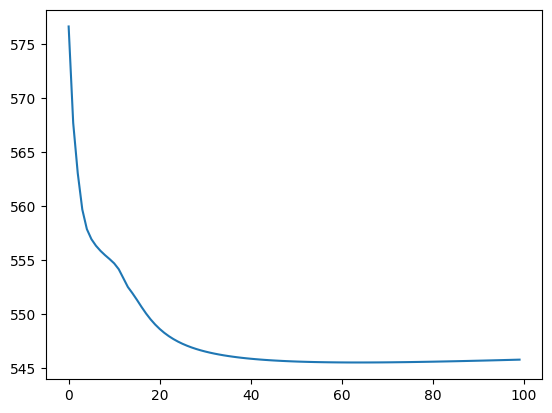

In [13]:
# Plot loss
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model losses during training")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["train", "test"], loc="upper right")
plt.show()

In [ ]:
scann_layer = tfrs.layers.factorized_top_k.ScaNN(
    retrieval_model.query_tower,
    k = 10,
)

scann_layer.index_from_dataset(
  tf.data.Dataset.zip(
      (
          movies_dataset.map(lambda movie: movie['movie_id']).batch(100),
          candidates_corpus_dataset.batch(100).map(retrieval_model.candidate_tower)
      )
  )
)

user_id = '41'
afinity_scores, movie_ids = scann_layer(
    {
        'user_id': tf.convert_to_tensor([user_id])
    }
)

print(f"Recommendations for user {user_id} using ScaNN: {movie_ids[0, :5]} (Confidences: {afinity_scores[0, :5]})")